Now we want to predict pokemon type

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
dataset = pd.read_csv('Pokemon.csv')
print 'total rows: ' + str(dataset.shape[0])
print 'total columns: ' + str(dataset.shape[1])
dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset = dataset.iloc[:, 2:]
dataset.head()

total rows: 800
total columns: 13


,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
710,Dragon,Ice,660,125,130,90,130,90,95,5,True
799,Fire,Water,600,80,110,120,130,90,70,6,True
52,Bug,Grass,405,60,95,80,60,80,30,1,False
638,Psychic,NaN,290,45,30,40,105,50,20,5,False
250,Ground,NaN,330,90,60,60,40,40,40,2,False


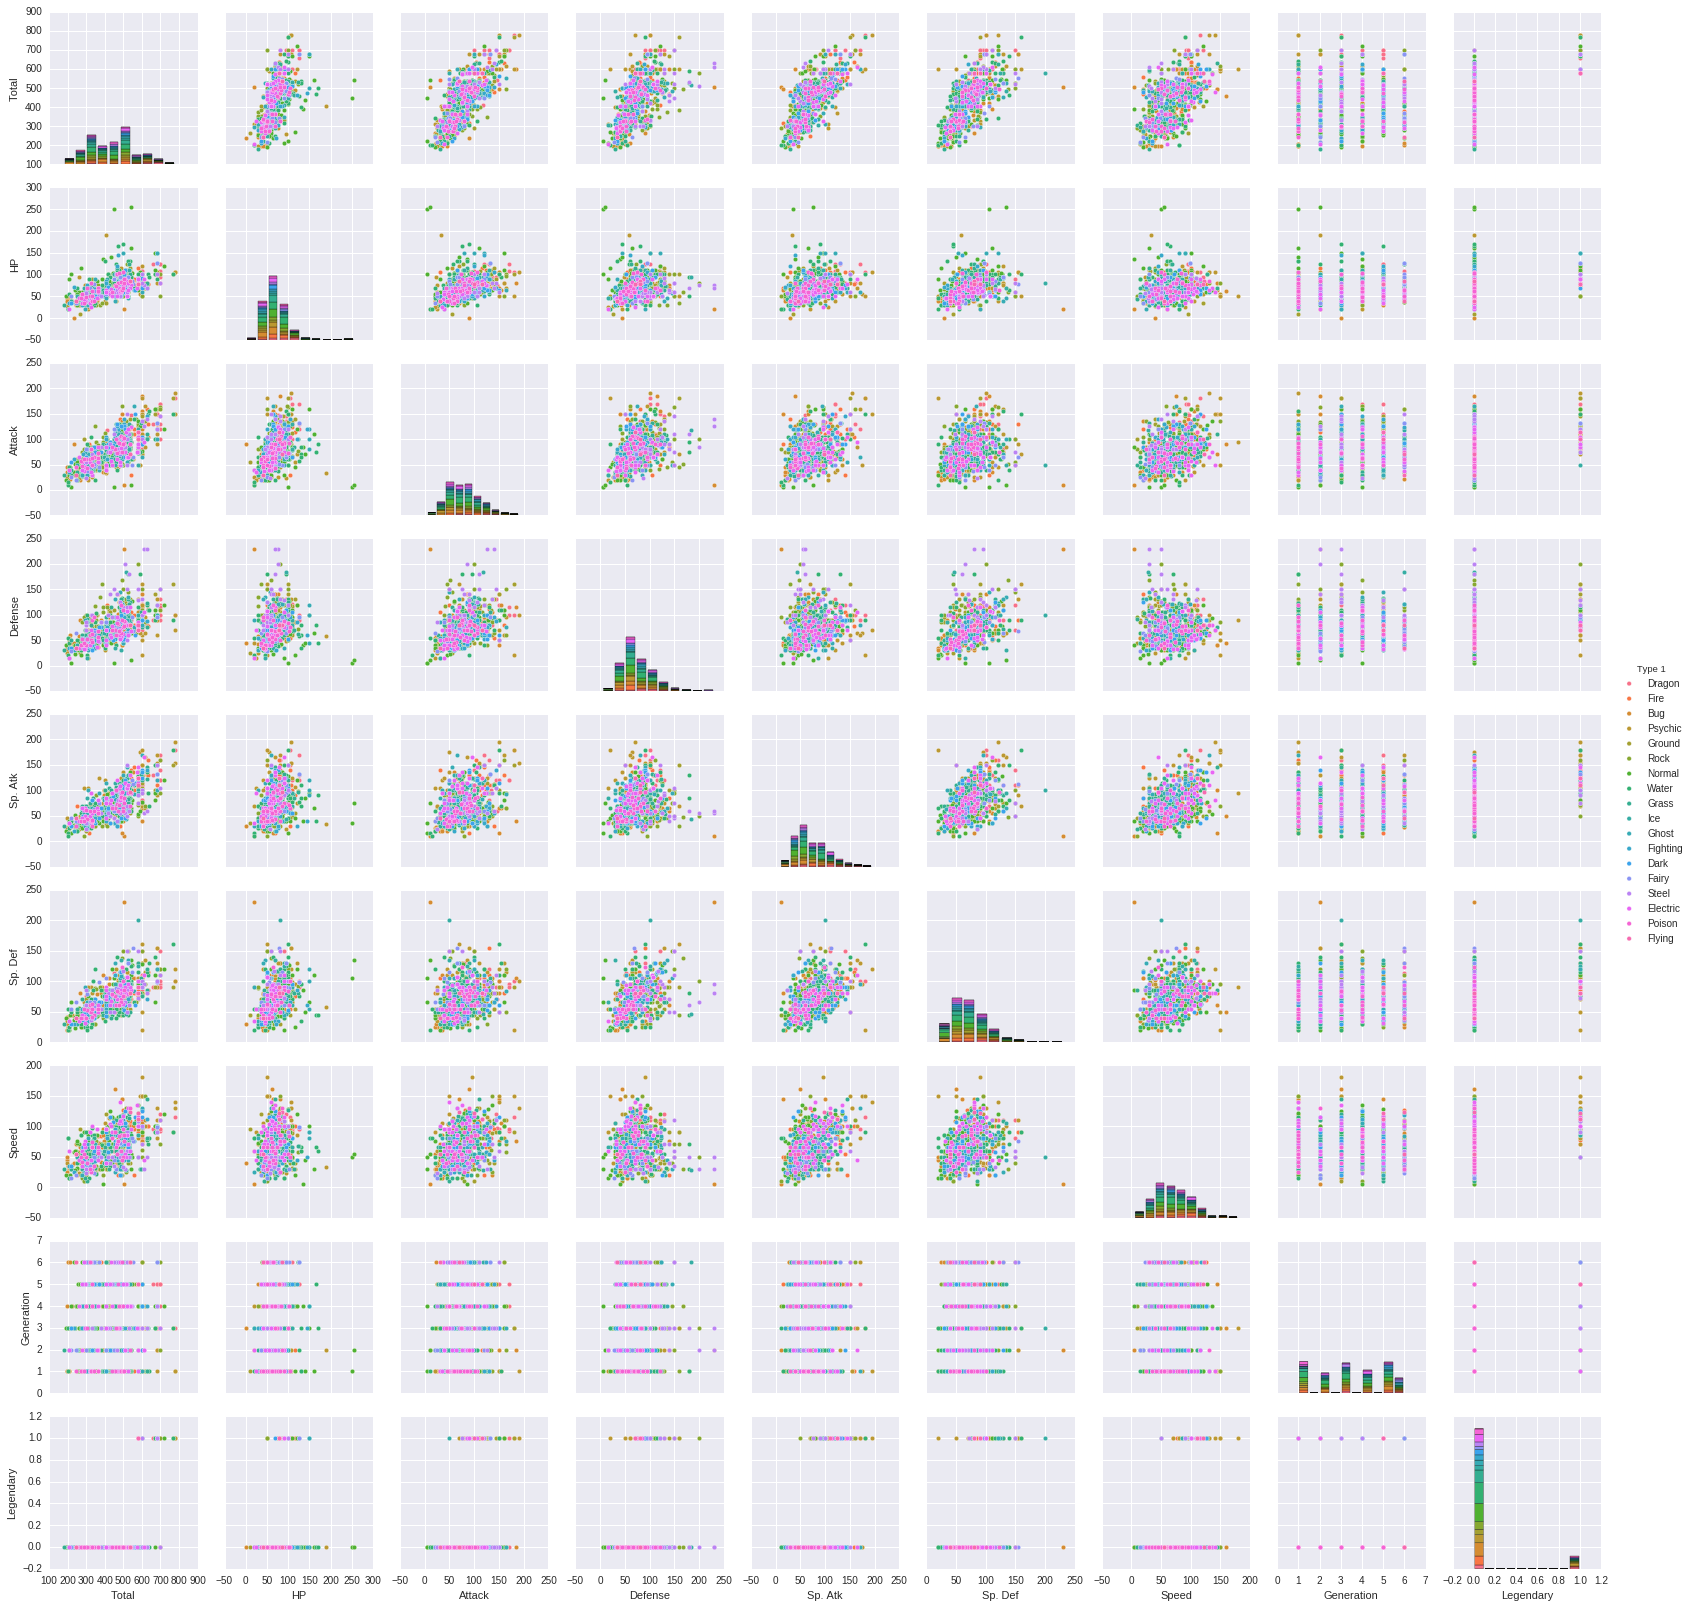

In [3]:
sns.pairplot(dataset, hue="Type 1")
plt.show()

Herm, this is hard, YOLO?

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

dataset = dataset.fillna(value = 'none')
x_data = dataset.iloc[:, 1:].values
x_data[:, 0] = LabelEncoder().fit_transform(x_data[:, 0])
x_data[:, -1] = LabelEncoder().fit_transform(x_data[:, -1])
x_data = StandardScaler().fit_transform(x_data)
y_datalabel = dataset.iloc[:, 0]
y_data = LabelEncoder().fit_transform(dataset.iloc[:, 0])

onehot = np.zeros((y_data.shape[0], np.unique(y_data).shape[0]))
for i in xrange(y_data.shape[0]):
    onehot[i, y_data[i]] = 1.0
    
x_train, x_test, y_train, y_test, _, y_test_label = train_test_split(x_data, onehot, y_data, test_size = 0.2)

print np.unique(y_datalabel)
print np.unique(y_data)

['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [14]:
size_layer_first = 512
size_layer_second = 256
learning_rate = 0.1
beta = 0.0005

X = tf.placeholder("float", [None, x_train.shape[1]])
Y = tf.placeholder("float", [None, np.unique(y_data).shape[0]])
layer1 = tf.Variable(tf.random_normal([x_train.shape[1], size_layer_first]))
layer2 = tf.Variable(tf.random_normal([size_layer_first, size_layer_first]))
layer3 = tf.Variable(tf.random_normal([size_layer_first, size_layer_second]))
layer4 = tf.Variable(tf.random_normal([size_layer_second, np.unique(y_data).shape[0]]))

bias1 = tf.Variable(tf.random_normal([size_layer_first], stddev = 0.1))
bias2 = tf.Variable(tf.random_normal([size_layer_first], stddev = 0.1))
bias3 = tf.Variable(tf.random_normal([size_layer_second], stddev = 0.1))
bias4 = tf.Variable(tf.random_normal([np.unique(y_data).shape[0]], stddev = 0.1))

hidden1 = tf.nn.relu(tf.matmul(X, layer1) + bias1)
hidden2 = tf.nn.relu(tf.matmul(hidden1, layer2) + bias2)
hidden3 = tf.nn.relu(tf.matmul(hidden2, layer3) + bias3)
hidden4 = tf.matmul(hidden3, layer4) + bias4

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = hidden4))
loss += tf.nn.l2_loss(layer1) * beta + tf.nn.l2_loss(layer2) * beta + tf.nn.l2_loss(layer3) * beta + tf.nn.l2_loss(layer4) * beta

optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate).minimize(loss)

correct_pred = tf.equal(tf.argmax(hidden4, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [15]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

BATCH_SIZE = 30

EPOCH, LOSS, ACC = [], [], []
for i in xrange(500):
    last = time.time()
    EPOCH.append(i)
    TOTAL_LOSS, ACCURACY = 0, 0
    for n in xrange(0, (x_train.shape[0] // BATCH_SIZE) * BATCH_SIZE, BATCH_SIZE):
        cost, _ = sess.run([loss, optimizer], feed_dict = {X : x_train[n: n + BATCH_SIZE, :], Y : y_train[n: n + BATCH_SIZE, :]})
        ACCURACY += sess.run(accuracy, feed_dict = {X : x_train[n: n + BATCH_SIZE, :], Y : y_train[n: n + BATCH_SIZE, :]})
        TOTAL_LOSS += cost
    
    TOTAL_LOSS /= (x_train.shape[0] // BATCH_SIZE)
    ACCURACY /= (x_train.shape[0] // BATCH_SIZE)
    LOSS.append(TOTAL_LOSS); ACC.append(ACCURACY)
    timetaken = (time.time() - last) / ((x_train.shape[0] // BATCH_SIZE) * 1.0)
    if (i + 1) % 50 == 0:
        print 'epoch: ' + str(i + 1) + ', loss: ' + str(TOTAL_LOSS) + ', accuracy: ' + str(ACCURACY) + ', s / batch: ' + str(timetaken)

epoch: 50, loss: 98.9914053054, accuracy: 1.0, s / batch: 0.00424556505112
epoch: 100, loss: 96.3048498971, accuracy: 1.0, s / batch: 0.00443119094485
epoch: 150, loss: 93.9661102295, accuracy: 1.0, s / batch: 0.0072919073559
epoch: 200, loss: 91.9016894386, accuracy: 1.0, s / batch: 0.0050759542556
epoch: 250, loss: 90.0416190738, accuracy: 1.0, s / batch: 0.00537100292387
epoch: 300, loss: 90.7600733439, accuracy: 0.996825394176, s / batch: 0.00436375254676
epoch: 350, loss: 86.7989818028, accuracy: 1.0, s / batch: 0.00461157162984
epoch: 400, loss: 85.3555079869, accuracy: 1.0, s / batch: 0.00454023906163
epoch: 450, loss: 84.0044773647, accuracy: 1.0, s / batch: 0.00522595360166
epoch: 500, loss: 82.7313581194, accuracy: 1.0, s / batch: 0.00447619528998


In [16]:
from sklearn import metrics
testing_acc, logits = sess.run([accuracy, tf.cast(tf.argmax(hidden4, 1), tf.int32)], feed_dict = {X : x_test, Y : y_test})
print 'testing accuracy: ' + str(testing_acc)
print(metrics.classification_report(y_test_label, logits, target_names = np.unique(y_datalabel)))

testing accuracy: 0.2
             precision    recall  f1-score   support

        Bug       0.36      0.33      0.34        15
       Dark       0.00      0.00      0.00         8
     Dragon       0.15      0.29      0.20         7
   Electric       0.57      0.40      0.47        10
      Fairy       0.00      0.00      0.00         1
   Fighting       0.29      0.50      0.36         4
       Fire       0.06      0.12      0.08         8
     Flying       0.00      0.00      0.00         0
      Ghost       0.25      0.29      0.27         7
      Grass       0.00      0.00      0.00        15
     Ground       0.00      0.00      0.00         6
        Ice       0.33      0.12      0.18         8
     Normal       0.41      0.35      0.38        20
     Poison       0.00      0.00      0.00         3
    Psychic       0.44      0.40      0.42        10
       Rock       0.00      0.00      0.00         5
      Steel       0.50      0.14      0.22         7
      Water       0.17 

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


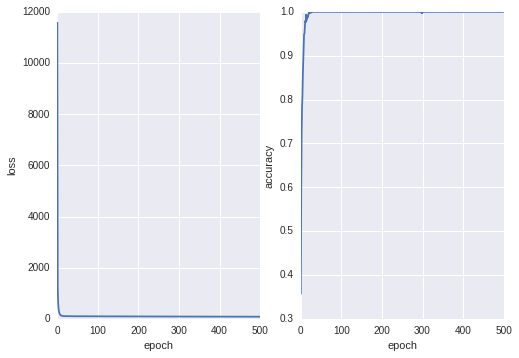

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.subplot(1, 2, 1)
plt.plot(EPOCH, LOSS)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACC)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()

# Overfit